# Machine learning for Geolocalisation

In [400]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vincenty import vincenty # geopy.distance can also be used
import plotly.figure_factory as ff
import plotly.express as px
import pandas_profiling

from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_validate

Nous chargeons les différents datasets (train,test ainsi que les positions à prédire du train set).

In [401]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')

In [402]:
df_mess_train

messid  bsid       did  nseq        rssi  \
0      573bf1d9864fce1a9af8c5c9  2841  473335.0   0.5 -121.500000   
1      573bf1d9864fce1a9af8c5c9  3526  473335.0   2.0 -125.000000   
2      573bf3533e952e19126b256a  2605  473335.0   1.0 -134.000000   
3      573c0cd0f0fe6e735a699b93  2610  473953.0   2.0 -132.000000   
4      573c0cd0f0fe6e735a699b93  3574  473953.0   1.0 -120.000000   
...                         ...   ...       ...   ...         ...   
39245  5848672e12f14360d7942374  3410  476257.0   1.0 -128.000000   
39246  5848672e12f14360d7942374  8352  476257.0   0.0 -121.000000   
39247  5848672e12f14360d7942374  8397  476257.0   2.0 -126.000000   
39248  58487473e541cd0e133cca72  3051  476593.0   1.0 -131.333333   
39249  58487473e541cd0e133cca72  7692  476593.0   1.5 -135.000000   

            time_ux     bs_lat      bs_lng  
0      1.463546e+12  39.617794 -104.954917  
1      1.463546e+12  39.677251 -104.952721  
2      1.463547e+12  39.612745 -105.008827  
3      1.463553e+12  39.797969 -105.073460  
4      1.463553e+12  39.723151 -104.956216  
...             ...        ...         ...  
39245  1.481140e+12  39.777690 -105.002424  
39246  1.481140e+12  39.761633 -105.025753  
39247  1.481140e+12  39.759396 -105.001415  
39248  1.481143e+12  39.898872 -105.153832  
39249  1.481143e+12  39.928436 -105.172719  

[39250 rows x 8 columns]

Analysons le dataset :

In [403]:
pandas_profiling.ProfileReport(df_mess_train)

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [404]:
fig = px.scatter_mapbox(df_mess_train[['bs_lat','bs_lng']], lat='bs_lat', lon='bs_lng',zoom=12,height=800 ,color_continuous_scale="Icefire")
fig.update_layout(mapbox_style="open-street-map")
fig.show()

Les datasets contiennent donc pour chaque message, les différentes bornes (bsid) qui l'ont capté avec les différentes caractéristiques des signaux captés (rssi, time_ux, lattitude des bornes, longitudes des bornes...)

La première chose qui saute aux yeux en regardant la map, c'est qu'il existe, une ou plusieurs bornes très éloignées au dessus du Canada. Ces bornes ont capté beaucoup de messages Id, il faudra garder leur données mais nettoyer les bornes. On peut remarquer que ces bornes ont capté des signaux avec un rssi semblable à ceux situés proches de Denver. Nous pouvons supposer que c'est la caractéristique bs_lat et bs_lng qui est faussée. Il faudra donc la corriger. Pour cela nous allons pour chacune de ces bases Stations, prendre la latitude et longitude minimum des messages captés dans le train par cette borne. Cela nous rapporchera déjà de la vrai position de ces bases.

Ensuite nous avons remarqué qu'il existe, différentes bases stations avec la même position. Cela semble aussi être une erreur. Nous allons donc pour chaque BS avec la même position considéré qu'il ne s'agit que d'une seule BS.

Le pre-processing ci-dessous servira à corriger ces 2 principaux problèmes.

## Modifcation des bornes localisées au dessus du Canada et des bornes en double sur une même position

In [405]:
BSCanadaTrain = np.unique(df_mess_train[(df_mess_train['bs_lat']==64.3)&(df_mess_train['bs_lng']==-68.5)]['bsid'])
len(BSCanadaTrain)

27

Il y a donc 27 BS situées au dessus du Canada dans le train set.

In [406]:
BSCanadaTest=np.unique(df_mess_test[(df_mess_test['bs_lat']==64.3)&(df_mess_test['bs_lng']==-68.5)]['bsid'])
len(BSCanadaTest)

23

Il y a donc 23 BS situées au dessus du Canada dans le test set.

In [407]:
y=[]
for i in BSCanadaTest:
    if i not in BSCanadaTrain:
        y.append(i)
y

[9941, 9949]

Les 2 BS 9941 et 9949, ne sont pas présentes dans le train set. Pour ces deux BS, nous ne pouvons donc pas prendre la latitude et longitude minimum des messages captés dans le train par ces bornes. Nous allons donc supposer qu'elles sont situées au point moyen de toutes les BS du train qui étaient au dessus du Canada.

In [408]:
#Nous localisons les lattitudes et longitudes minimum des messages pour les BS situées au dessus du Canada
dfNet=pd.concat([df_mess_train, pos_train],axis = 1)
dfStatCanada=dfNet[dfNet['bsid'].isin(BSCanadaTrain)]
dfStatCanada=dfStatCanada.groupby('bsid').agg({'lat': 'min','lng': 'min'})

# Lattitude et Logitude pour les 2 BS du test non présentes dans le train.
latTest=dfStatCanada['lat'].mean()
lngTest=dfStatCanada['lng'].mean()

dfStatCanadaTest=pd.DataFrame([[latTest, lngTest], [latTest, lngTest]], index=[9941, 9949], columns=['lat', 'lng'])
dfStatCanada=pd.concat([dfStatCanada,dfStatCanadaTest],axis = 0)

#modification des bs_lat et bs_lng dans le train set pour les BS soi-disant situées au dessus du Canada

ListLigneModif=df_mess_train[df_mess_train['bsid'].isin(BSCanadaTrain)].index.to_list()

for i in ListLigneModif:
    df_mess_train.at[i,'bs_lat']=dfStatCanada.loc[df_mess_train.iloc[i]['bsid']]['lat']
    df_mess_train.at[i,'bs_lng']=dfStatCanada.loc[df_mess_train.iloc[i]['bsid']]['lng']

# Nous considérons que chaque BS avec la même position considéré sont une seule BS
    
dfStatNoDuplica=df_mess_train[['bsid', 'bs_lat', 'bs_lng']].drop_duplicates()

Lat_long=df_mess_train[['bs_lat', 'bs_lng']].drop_duplicates()

ligneStatGarde=Lat_long.index.to_list()

dfStatFinal= dfStatNoDuplica.loc[ligneStatGarde]

ListRowCleaning=df_mess_train[df_mess_train['bsid'].isin(dfStatFinal['bsid'].to_list())==False].index.to_list()

ligneModifie=[]
for j in ListRowCleaning:
    for i in range(len(dfStatFinal)):
        if df_mess_train.iloc[j][['bs_lat', 'bs_lng']].to_list()==dfStatFinal.iloc[i][['bs_lat', 'bs_lng']].to_list():
                df_mess_train.at[j,'bsid']=dfStatNoDuplica.iloc[i]['bsid']
                ligneModifie.append(j)

In [409]:
#modification des bs_lat et bs_lng dans le test set pour les BS soi-disant situées au dessus du Canada

ListLigneModifTest=df_mess_test[df_mess_test['bsid'].isin(BSCanadaTest)].index.to_list()

for i in ListLigneModifTest:
    df_mess_test.at[i,'bs_lat']=dfStatCanada.loc[df_mess_test.iloc[i]['bsid']]['lat']
    df_mess_train.at[i,'bs_lng']=dfStatCanada.loc[df_mess_test.iloc[i]['bsid']]['lng']
    
# Nous considérons que chaque BS avec la même position considéré sont une seule BS
    
dfStatNoDuplicaTest=df_mess_test[['bsid', 'bs_lat', 'bs_lng']].drop_duplicates()

Lat_longTest=df_mess_test[['bs_lat', 'bs_lng']].drop_duplicates()

ligneStatGardeTest=Lat_longTest.index.to_list()

dfStatFinalTest= dfStatNoDuplicaTest.loc[ligneStatGardeTest]

ListRowCleaningTest=df_mess_test[df_mess_test['bsid'].isin(dfStatFinalTest['bsid'].to_list())==False].index.to_list()

ligneModifieTest=[]
for j in ListRowCleaningTest:
    for i in range(len(dfStatFinalTest)):
        if df_mess_test.iloc[j][['bs_lat', 'bs_lng']].to_list()==dfStatFinalTest.iloc[i][['bs_lat', 'bs_lng']].to_list():
                df_mess_test.at[j,'bsid']=dfStatNoDuplicaTest.iloc[i]['bsid']
                ligneModifieTest.append(j)

Nous voyons bien maintenant sur la carte que les BS situées auparavant au delà du Canada, sont maintenant à une position plus raisonnable.

In [410]:
fig = px.scatter_mapbox(df_mess_train[['bs_lat','bs_lng']], lat='bs_lat', lon='bs_lng',zoom=12,height=800 ,color_continuous_scale="Icefire")
fig.update_layout(mapbox_style="open-street-map")
fig.show()

## Cleaning

Nous voulons triangulariser les messages grâce aux BS qui ont captées leur signaux. Pour ceci, le mieux est de ne prendre que des messages qui ont été captés par au moins 3 BS. Cela donnera beaucoup plus de précision à la triangualrisation.

In [411]:
def cleaning(df):
    return df.groupby('messid').filter(lambda x: x['bsid'].count()>2).index

In [412]:
validindexes=cleaning(df_mess_train)

In [413]:
pos_train=pos_train.iloc[validindexes]
df_mess_train=df_mess_train.iloc[validindexes]
df_mess_train

messid  bsid       did  nseq        rssi  \
3      573c0cd0f0fe6e735a699b93  2610  473953.0   2.0 -132.000000   
4      573c0cd0f0fe6e735a699b93  3574  473953.0   1.0 -120.000000   
5      573c0cd0f0fe6e735a699b93  8474  473953.0   2.0 -100.000000   
6      573c1272f0fe6e735a6cb8bd  1859  476512.0   1.0 -123.333333   
7      573c1272f0fe6e735a6cb8bd  2605  476512.0   1.0 -129.666667   
...                         ...   ...       ...   ...         ...   
39243  5848672e12f14360d7942374  1859  476257.0   1.0 -129.000000   
39244  5848672e12f14360d7942374  2943  476257.0   1.5 -115.000000   
39245  5848672e12f14360d7942374  3410  476257.0   1.0 -128.000000   
39246  5848672e12f14360d7942374  8352  476257.0   0.0 -121.000000   
39247  5848672e12f14360d7942374  8397  476257.0   2.0 -126.000000   

            time_ux     bs_lat      bs_lng  
3      1.463553e+12  39.797969 -105.073460  
4      1.463553e+12  39.723151 -104.956216  
5      1.463553e+12  39.732045 -104.973651  
6      1.463555e+12  39.704887 -105.016392  
7      1.463555e+12  39.612745 -105.008827  
...             ...        ...         ...  
39243  1.481140e+12  39.704887 -105.016392  
39244  1.481140e+12  39.702761 -105.036301  
39245  1.481140e+12  39.777690 -105.002424  
39246  1.481140e+12  39.761633 -105.025753  
39247  1.481140e+12  39.759396 -105.001415  

[36015 rows x 8 columns]

## ----------------
Nous listons les différentes Bases Stations dans le train et le test set pour pouvoir construire notre matrice de features. Il y en a au total 247.

In [414]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message


In [415]:
len(listOfBs)

247

## Feature Matrix construction

In [416]:
def feat_mat_const(df_mess_train, listOfBs):

    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
        df_mess_bs_group.get_group(key)
        df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid']] = [elmt['rssi']]#1
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message  

Au lieu de 1 dans la matrice feat_mat_const, nous allons faire 2 matrice feat_mat_const : 

* une pour prédire la lattitude : feat_mat_constLat
* une pour prédire la longitude : feat_mat_constLong

De plus au lieu de mettre 1 nous mettrons $ \frac{lat}{log(-rssi)} $  et $ \frac{lng}{log(-rssi)} $ . Nous avons associés des poids proportionnels à la puissance du signal. Plus le RSSI est négatif, plus celui-ci est faible, nous divisns donc par log(-rssi) pour avoir un poids inversement proportionnels à la puissance.

In [417]:
def feat_mat_constLat(df_mess_train, listOfBs):

    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
        df_mess_bs_group.get_group(key)
        df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid']] = [elmt['bs_lat']*(1/np.log(-elmt['rssi']))]
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message  

In [418]:
def feat_mat_constLong(df_mess_train, listOfBs):

    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
        df_mess_bs_group.get_group(key)
        df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid']] = [elmt['bs_lng']*(1/np.log(-elmt['rssi']))]
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message  

La matrice ground_truth_const est construite ci- dessous et reste inchangée. Elle servira de y_train.

In [419]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])

    return ground_truth_lat, ground_truth_lng

In [420]:
df_feat, id_list_train = feat_mat_const(df_mess_train, listOfBs)
df_feat

879    911    921    944    980    1012   1086   1092   1120   1131   \
0       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2       0.0    0.0    0.0    0.0    0.0    0.0 -141.0    0.0    0.0    0.0   
3       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
3781    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3782    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3783    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3784    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3785    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

      ...  9783   9899   9936   9949   10134  10148  10151  10162  11007  \
0     ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1     ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2     ...    0.0 -129.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3     ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4     ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
3781  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3782  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3783  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3784  ...    0.0 -131.0    0.0    0.0    0.0    0.0 -122.0    0.0 -121.0   
3785  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

      11951  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
...     ...  
3781    0.0  
3782    0.0  
3783    0.0  
3784    0.0  
3785    0.0  

[3786 rows x 247 columns]

In [421]:
df_featLat, id_list_trainLat = feat_mat_constLat(df_mess_train, listOfBs)
df_featLat

879    911    921    944    980    1012      1086   1092   1120   1131   \
0       0.0    0.0    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
1       0.0    0.0    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
2       0.0    0.0    0.0    0.0    0.0    0.0  8.077578    0.0    0.0    0.0   
3       0.0    0.0    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
4       0.0    0.0    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
...     ...    ...    ...    ...    ...    ...       ...    ...    ...    ...   
3781    0.0    0.0    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
3782    0.0    0.0    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
3783    0.0    0.0    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
3784    0.0    0.0    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   
3785    0.0    0.0    0.0    0.0    0.0    0.0  0.000000    0.0    0.0    0.0   

      ...  9783      9899   9936   9949   10134  10148     10151  10162  \
0     ...    0.0  0.000000    0.0    0.0    0.0    0.0  0.000000    0.0   
1     ...    0.0  0.000000    0.0    0.0    0.0    0.0  0.000000    0.0   
2     ...    0.0  8.187847    0.0    0.0    0.0    0.0  0.000000    0.0   
3     ...    0.0  0.000000    0.0    0.0    0.0    0.0  0.000000    0.0   
4     ...    0.0  0.000000    0.0    0.0    0.0    0.0  0.000000    0.0   
...   ...    ...       ...    ...    ...    ...    ...       ...    ...   
3781  ...    0.0  0.000000    0.0    0.0    0.0    0.0  0.000000    0.0   
3782  ...    0.0  0.000000    0.0    0.0    0.0    0.0  0.000000    0.0   
3783  ...    0.0  0.000000    0.0    0.0    0.0    0.0  0.000000    0.0   
3784  ...    0.0  8.162009    0.0    0.0    0.0    0.0  8.263627    0.0   
3785  ...    0.0  0.000000    0.0    0.0    0.0    0.0  0.000000    0.0   

        11007  11951  
0     0.00000    0.0  
1     0.00000    0.0  
2     0.00000    0.0  
3     0.00000    0.0  
4     0.00000    0.0  
...       ...    ...  
3781  0.00000    0.0  
3782  0.00000    0.0  
3783  0.00000    0.0  
3784  8.27711    0.0  
3785  0.00000    0.0  

[3786 rows x 247 columns]

In [422]:
df_featLong, id_list_trainLat = feat_mat_constLong(df_mess_train, listOfBs)
df_featLong

879    911    921    944    980    1012       1086   1092   1120   \
0       0.0    0.0    0.0    0.0    0.0    0.0   0.000000    0.0    0.0   
1       0.0    0.0    0.0    0.0    0.0    0.0   0.000000    0.0    0.0   
2       0.0    0.0    0.0    0.0    0.0    0.0 -21.195556    0.0    0.0   
3       0.0    0.0    0.0    0.0    0.0    0.0   0.000000    0.0    0.0   
4       0.0    0.0    0.0    0.0    0.0    0.0   0.000000    0.0    0.0   
...     ...    ...    ...    ...    ...    ...        ...    ...    ...   
3781    0.0    0.0    0.0    0.0    0.0    0.0   0.000000    0.0    0.0   
3782    0.0    0.0    0.0    0.0    0.0    0.0   0.000000    0.0    0.0   
3783    0.0    0.0    0.0    0.0    0.0    0.0   0.000000    0.0    0.0   
3784    0.0    0.0    0.0    0.0    0.0    0.0   0.000000    0.0    0.0   
3785    0.0    0.0    0.0    0.0    0.0    0.0   0.000000    0.0    0.0   

      1131   ...  9783       9899   9936   9949   10134  10148      10151  \
0       0.0  ...    0.0   0.000000    0.0    0.0    0.0    0.0   0.000000   
1       0.0  ...    0.0   0.000000    0.0    0.0    0.0    0.0   0.000000   
2       0.0  ...    0.0 -21.611247    0.0    0.0    0.0    0.0   0.000000   
3       0.0  ...    0.0   0.000000    0.0    0.0    0.0    0.0   0.000000   
4       0.0  ...    0.0   0.000000    0.0    0.0    0.0    0.0   0.000000   
...     ...  ...    ...        ...    ...    ...    ...    ...        ...   
3781    0.0  ...    0.0   0.000000    0.0    0.0    0.0    0.0   0.000000   
3782    0.0  ...    0.0   0.000000    0.0    0.0    0.0    0.0   0.000000   
3783    0.0  ...    0.0   0.000000    0.0    0.0    0.0    0.0   0.000000   
3784    0.0  ...    0.0 -21.543047    0.0    0.0    0.0    0.0 -21.874704   
3785    0.0  ...    0.0   0.000000    0.0    0.0    0.0    0.0   0.000000   

      10162      11007  11951  
0       0.0   0.000000    0.0  
1       0.0   0.000000    0.0  
2       0.0   0.000000    0.0  
3       0.0   0.000000    0.0  
4       0.0   0.000000    0.0  
...     ...        ...    ...  
3781    0.0   0.000000    0.0  
3782    0.0   0.000000    0.0  
3783    0.0   0.000000    0.0  
3784    0.0 -21.910043    0.0  
3785    0.0   0.000000    0.0  

[3786 rows x 247 columns]

In [423]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
ground_truth_lat.shape

(3786,)

In [424]:
ground_truth_lat

array([39.73041743, 39.69310197, 39.75816678, ..., 39.65880419,
       39.77887196, 39.77326419])

## Validation

La fonction ci-dessous nous permettra de prédire les positions de l'échantillon Test.

In [425]:
def regressor_and_predictTest(df_trainLat, df_trainLng, ground_truth_lat, ground_truth_lng, df_testLat, df_testLng):
    
    # train regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng


    X_trainLat = np.array(df_trainLat);
    reg = KNeighborsRegressor(n_neighbors=8, weights='distance',algorithm='brute', p=1)

    reg.fit(X_trainLat, ground_truth_lat);
    y_pred_lat = reg.predict(np.array(df_testLat))
    
    X_trainLng = np.array(df_trainLng);

    reg.fit(X_trainLng, ground_truth_lng);
    y_pred_lng = reg.predict(np.array(df_testLng))
    
    return y_pred_lat, y_pred_lng


## Test d'autres regressions

Parmi toutes les méthodes de prédiction essayées ci-dessous, la regression des K plus proches voisins a été la plus efficace. En effet celle ci va pour chaque message, trouver parmi les Bases Stations ayant capté ce message, les k plus proches. Une estimation de la postion du message est faite en moyennant la position de celles-ci.

In [426]:
reg = KNeighborsRegressor(n_neighbors=8, weights='distance',p=1)
#y_pred_lng = cross_val_predict(reg, df_featLong, ground_truth_lng, cv=10)
#y_pred_lat = cross_val_predict(reg, df_featLat, ground_truth_lat, cv=10)

In [427]:
regrf = RandomForestRegressor(max_depth=25, random_state=0)
#y_pred_lng = cross_val_predict(regrf, df_featLong, ground_truth_lng, cv=10)
#y_pred_lat = cross_val_predict(regrf, df_featLat, ground_truth_lat, cv=10)

In [428]:
reg = KNeighborsRegressor(weights='distance')#, p=1)
regAda = AdaBoostRegressor(base_estimator=reg,random_state=0, n_estimators=50, learning_rate=0.01)
#y_pred_lng = cross_val_predict(regAda, df_featLong, ground_truth_lng, cv=10)
#y_pred_lat = cross_val_predict(regAda, df_featLat, ground_truth_lat, cv=10)

In [430]:
#regGB = GradientBoostingRegressor(random_state=0, learning_rate=0.3,max_depth=10)
#y_pred_lng = cross_val_predict(regGB, df_featLong, ground_truth_lng, cv=10)
#y_pred_lat = cross_val_predict(regGB, df_featLat, ground_truth_lat, cv=10)

## Leave-one-out cross-validation

https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html

https://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.LeaveOneOut.html

Nous effectuons une Leave-one-out cross-validation ci-dessous.  Elle consiste à prédire pour chaque message id dans notre df_feat sa position à partir de tous les autres message ID en tant qu'échantillon train. 
La taille de l'échantillon test est donc de 1 et la taille train est donc de k-1 (k étant la nombre total de message ID). Nous répétons cette opération k fois pour obtenir k prédictions.

In [431]:
loo = LeaveOneOut()
nLong=loo.get_n_splits(df_featLong)
nLat=loo.get_n_splits(df_featLat)

reg = KNeighborsRegressor(n_neighbors=8, weights='distance',algorithm='brute', p=1)

#‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
#‘brute’ will use a brute-force search. Fitting on sparse input will override the setting of this parameter, using brute force.

y_pred_lng = cross_val_predict(reg, df_featLong, ground_truth_lng, cv=loo)
y_pred_lat = cross_val_predict(reg, df_featLat, ground_truth_lat, cv=loo)

## Evaluate result

In [432]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]) for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [433]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [434]:
err_vec = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)

## Plot error distribution

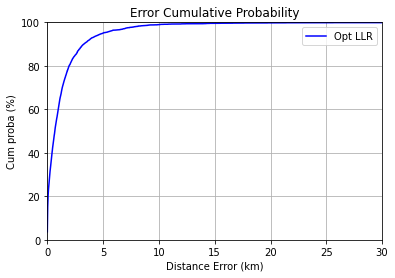

In [435]:
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1], cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

In [436]:
# Error criterion
np.percentile(err_vec, 80)

1.960398

En comparant la position réelle des émetteurs de l'échantillon train avec celle prédite par notre modèle,nous obtenons donc une précision à 1,96km près au 80e percentile. 

# Construct test prediction

In [437]:
df_featLat_test, id_list_test = feat_mat_constLat(df_mess_test, listOfBs)
df_featLong_test, id_list_test = feat_mat_constLong(df_mess_test, listOfBs)

In [438]:
y_pred_lat_test, y_pred_lng_test = regressor_and_predictTest(df_featLat, df_featLong, ground_truth_lat, ground_truth_lng, df_featLat_test, df_featLong_test)


In [439]:
test_res = pd.DataFrame(np.array([y_pred_lat_test, y_pred_lng_test]).T, columns = ['lat', 'lng'])
test_res['messid'] = id_list_test

In [440]:
test_res.to_csv('pred_pos_test_list.csv', index=False)

In [441]:
test_res.head()

lat         lng                    messid
0  39.767674 -105.124186  573be2503e952e191262c351
1  39.786107 -105.063728  573c05f83e952e1912758013
2  39.687627 -105.014065  573c0796f0fe6e735a66deb3
3  39.779102 -105.059916  573c08d2864fce1a9a0563bc
4  39.687137 -105.014914  573c08ff864fce1a9a0579b0

# Conclusion

Grâce au modèle des K plus proches voisins, nous avons constaté que plus le nombre de balises ayant reçu le signal est important plus le modèle sera précis.

De plus, il semblerait que certains balises soient mal configurées car elle sont géolocalisées au dessus Canada, alors qu'elles ne le sont probalement pas car elles captent les signaux envoyés par les émetteurs proches de Denver, or ces mêmes signaux ne sont pas captés par des balises beaucoup plus proches.